## 1.0 Introduction


In [384]:
# Author : Ahmad Fairuz Ali
# Date : 20 September 2017
# This is refering to the https://www.kaggle.com/c/nyc-taxi-trip-duration/data

In [385]:
import pandas as pd
# how to draw a pickup_datetime againts trip_duration? 
from pandas import Series
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
# Import Train_test_split
from sklearn.cross_validation import train_test_split
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import sklearn.base as base
from time import time

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn import pipeline

In [ ]:
# objective
# 1. Investigate the variables that influence the duration of the trip. (features selection) 
# 2. Based on individual trip attributes, predict the duration of each trip in the test set. ( machine learning )

In [ ]:
# the trip duration is our dependant variable
# the other attributes will be the independant variable 
#
#
# - pickup datetime (maybe strong features)
# - dropoff datetime (no need to consider as features )
# - passenger count (maybe weak features )
# - pickup longitude and latitude (maybe strong features )
# - dropoff longitude and latitude (maybe strong featurs )
# - store_and_fwd_flag (not sure ) 
#
#

In [ ]:
#nyx_taxi_data_2014 = pd.read_csv("nyc_taxi_data_2014.csv")

## 2.0  Training Data Set

In [386]:
train = pd.read_csv("train.csv")

In [387]:
train.shape

(1458644, 11)

In [388]:
train.shape[0] # the size

1458644

In [389]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [390]:
train['vendor_id'].astype(str).value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

## 2.1 Enrich the train dataset 

In [391]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
train['pickup_datetime_hour'] = train.pickup_datetime.dt.hour
train['pickup_datetime_time'] = train.pickup_datetime.dt.time
train['dropoff_datetime_time'] = train.dropoff_datetime.dt.time
train['dropoff_datetime_hour'] = train.dropoff_datetime.dt.hour
train['pickup_datetime_weektype'] = train.pickup_datetime.dt.weekday_name
train['dropoff_datetime_weektype'] = train.dropoff_datetime.dt.weekday_name
train['pickup_datetime_month'] = train.pickup_datetime.dt.month
train['dropoff_datetime_month'] = train.dropoff_datetime.dt.month
train['pickup_datetime_epoch'] = train.pickup_datetime.astype('int64')//10**9
train["store_and_fwd_flag"].replace(['N','Y'],[0,1],inplace=True)
train['pickup_datetime_day'] = train.pickup_datetime.dt.weekday

In [392]:
print(train.shape)
print(train.dtypes)
print(train.head(4))

(1458644, 21)
id                                   object
vendor_id                             int64
pickup_datetime              datetime64[ns]
dropoff_datetime             datetime64[ns]
passenger_count                       int64
pickup_longitude                    float64
pickup_latitude                     float64
dropoff_longitude                   float64
dropoff_latitude                    float64
store_and_fwd_flag                    int64
trip_duration                         int64
pickup_datetime_hour                  int64
pickup_datetime_time                 object
dropoff_datetime_time                object
dropoff_datetime_hour                 int64
pickup_datetime_weektype             object
dropoff_datetime_weektype            object
pickup_datetime_month                 int64
dropoff_datetime_month                int64
pickup_datetime_epoch                 int64
pickup_datetime_day                   int64
dtype: object
          id  vendor_id     pickup_datetime    d

In [393]:
#train.groupby(['dropoff_datetime_month']).sum()

In [394]:
!rm train_newdatetime.csv

In [395]:
train.to_csv("train_newdatetime.csv",index=False)

## 2.2 Visualizing the Train dataset

In [ ]:
train = pd.read_csv("train_newdatetime.csv")

## Which vendor is efficient ?

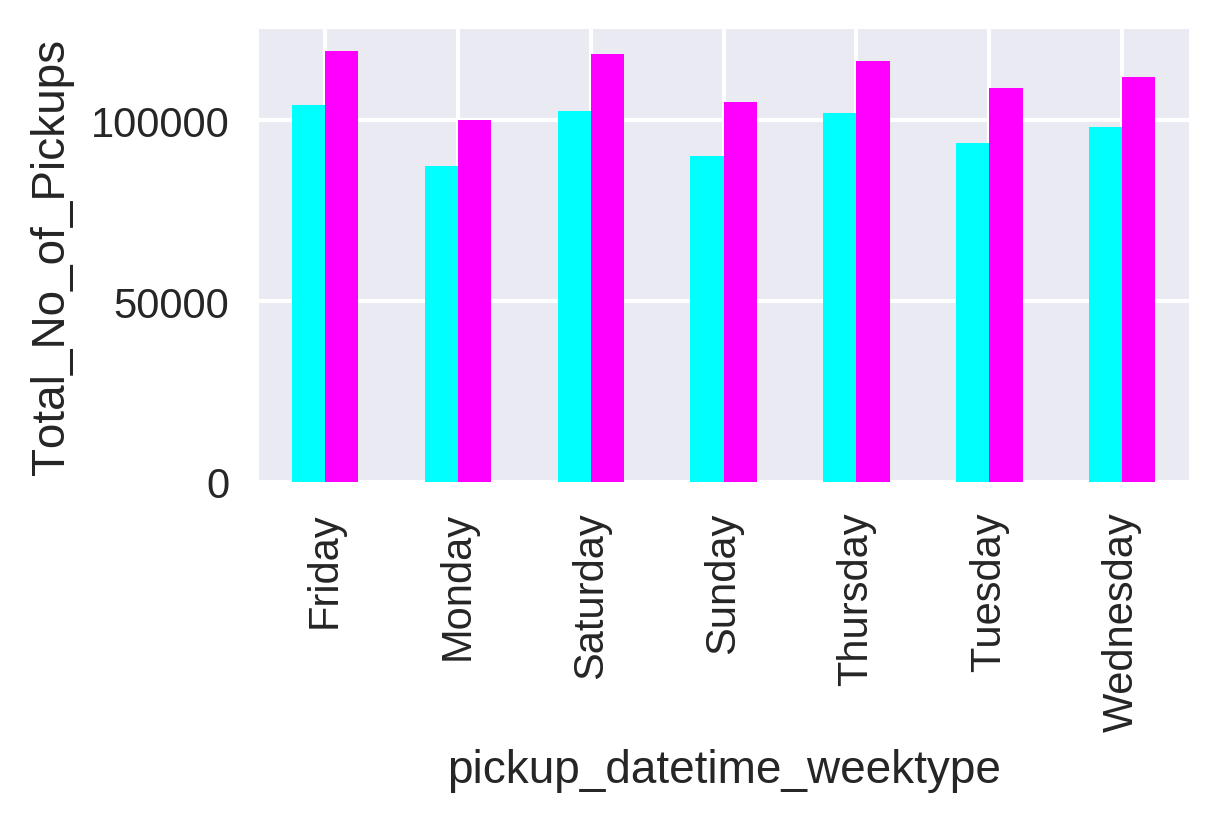

In [396]:
total_pickups=pd.DataFrame()
total_pickups=train.groupby(["pickup_datetime_weektype","vendor_id"]).size()
ax = total_pickups.unstack().plot(kind='bar',colormap='cool',legend=False,figsize=(4,2),)
#ax.text(x,"ok")
plt.ylabel('Total_No_of_Pickups')

## Which hour in which day is mostly high demand ?

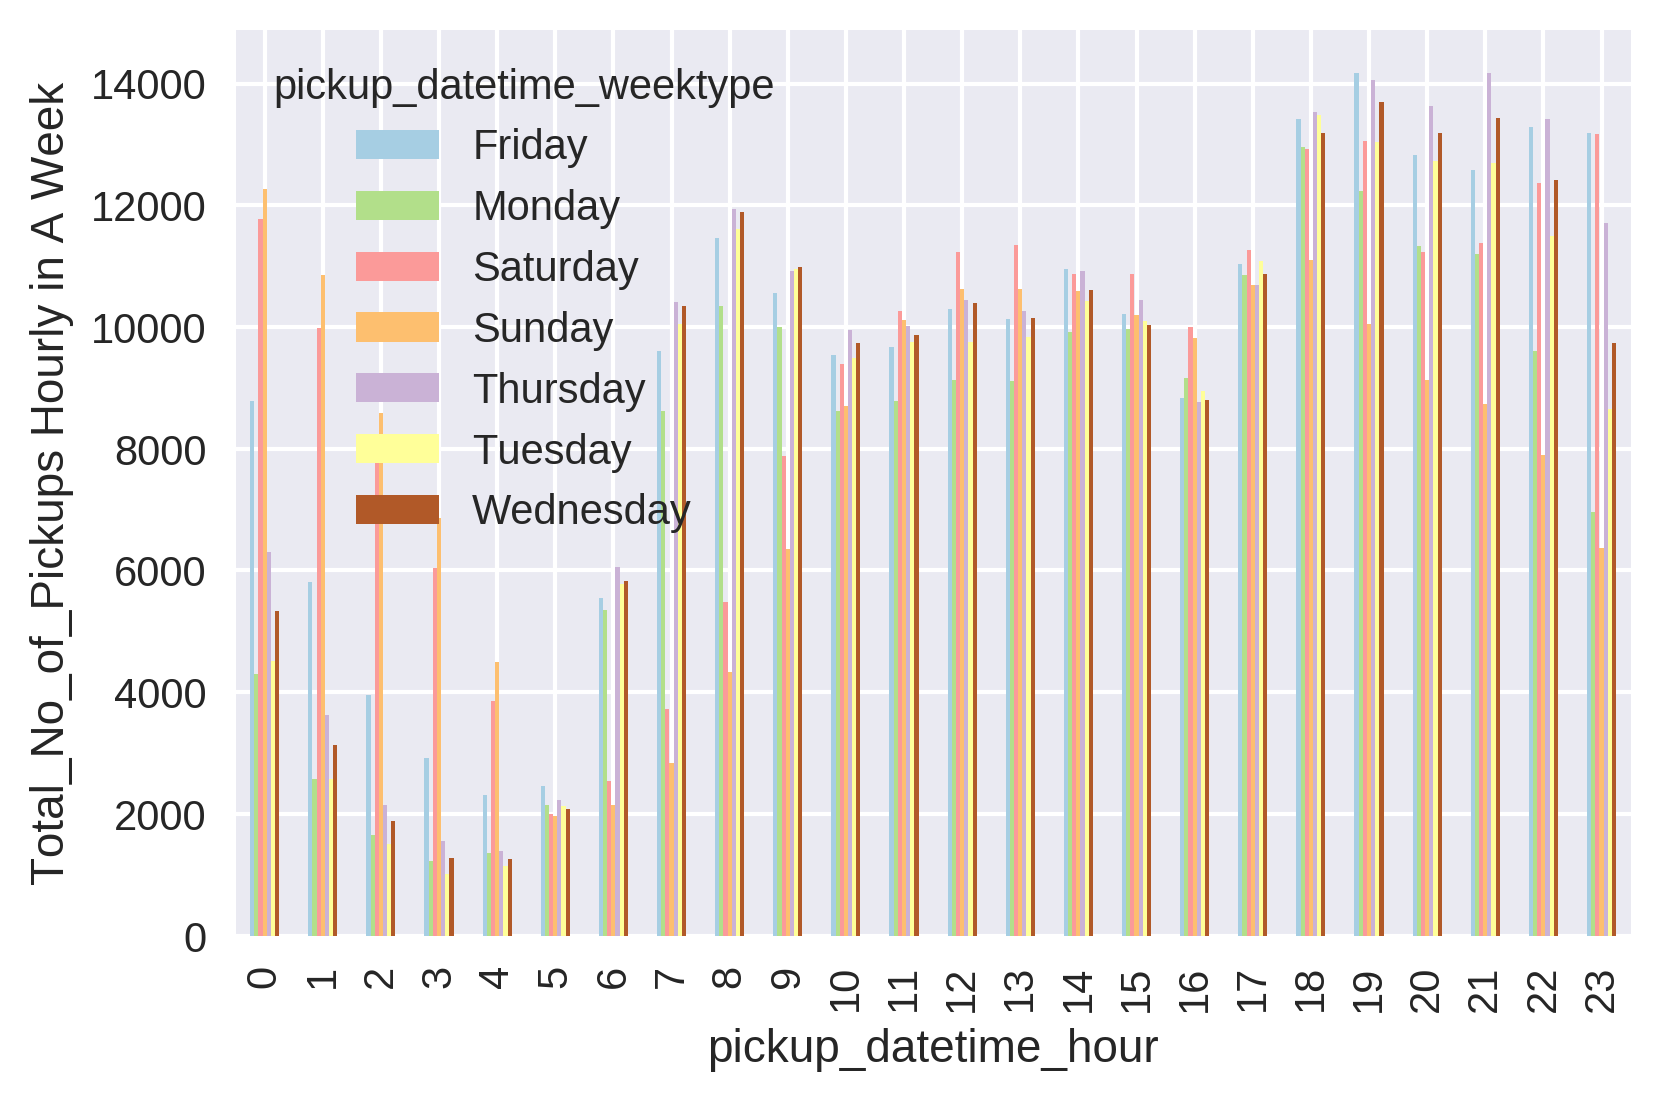

In [397]:
total_pickupshourly=pd.DataFrame()
total_pickupshourly=train.groupby(["pickup_datetime_hour","pickup_datetime_weektype"]).size()
total_pickupshourly.unstack().plot(kind='bar',colormap='Paired')
plt.ylabel('Total_No_of_Pickups Hourly in A Week')

## Which destination is popular ? (Drop Off)

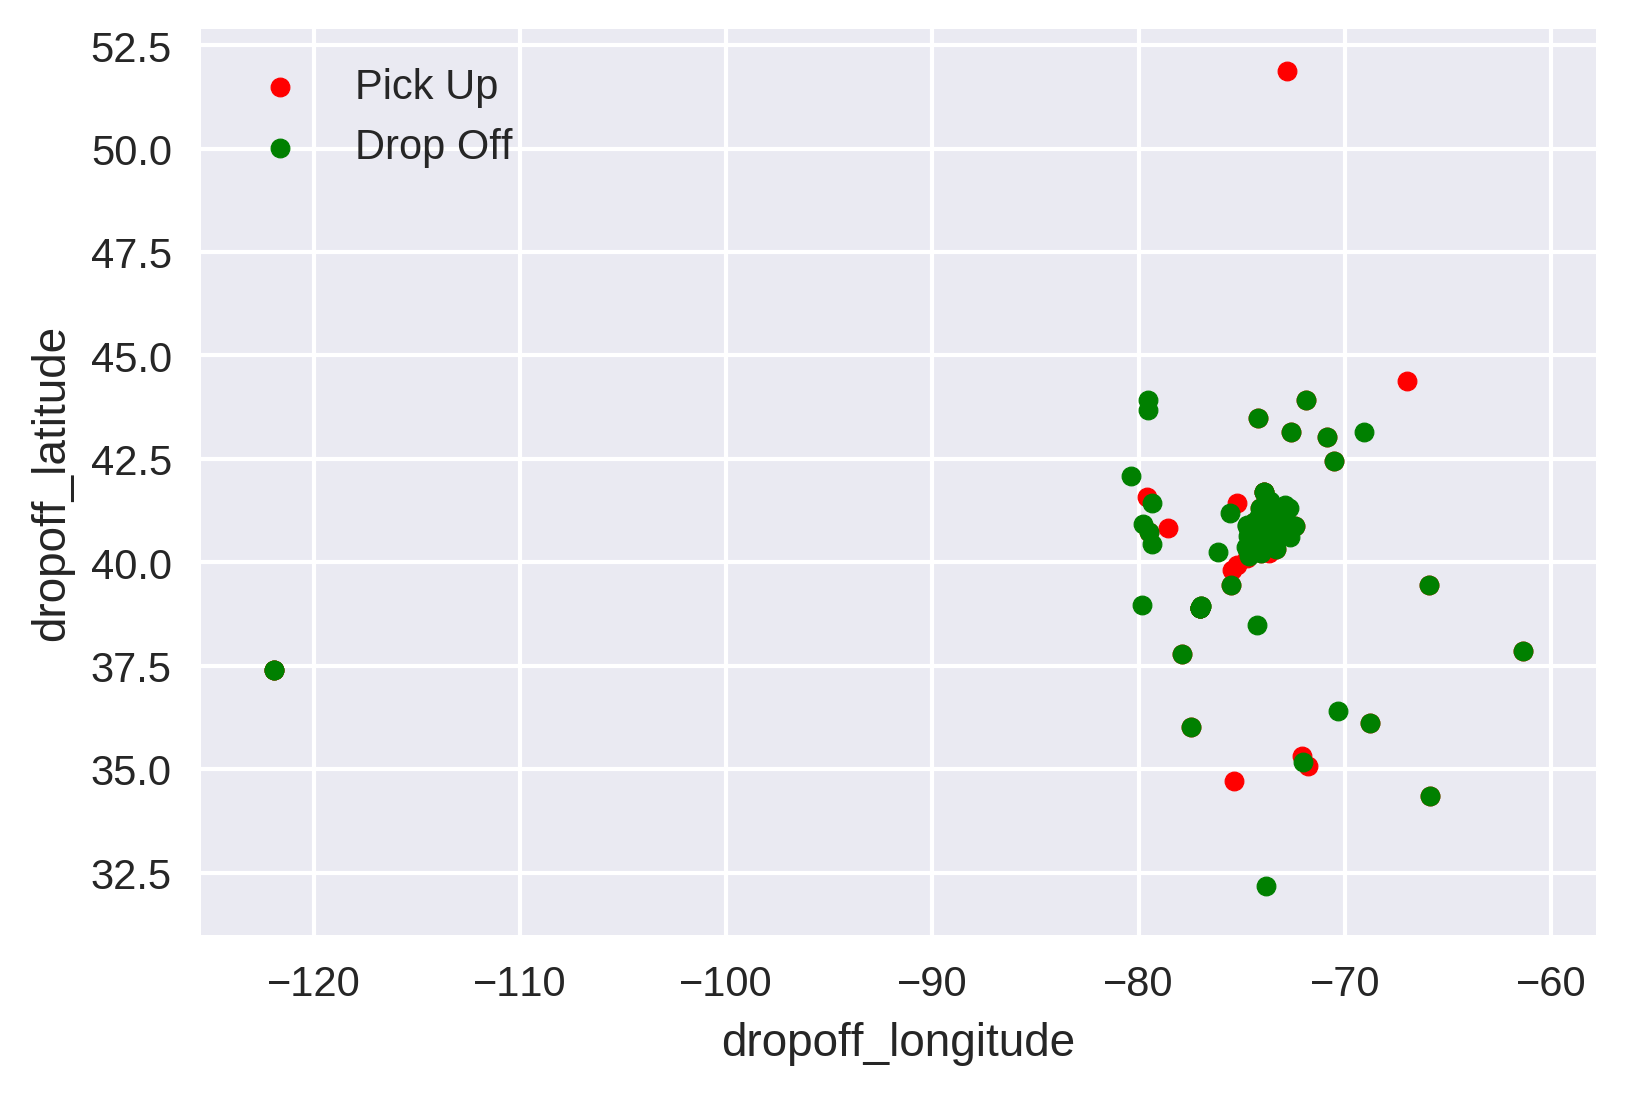

In [398]:
%matplotlib inline
ax1 = train.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", color='r', label="Pick Up")
train.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", color='g', ax=ax1, label="Drop Off")

## 3.0 Test Data

In [399]:
test = pd.read_csv("test.csv")

In [400]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [ ]:
test['vendor_id'].astype(str).value_counts()

## 3.1 Enrichment of Test Data

In [401]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
test['pickup_datetime_hour'] = test.pickup_datetime.dt.hour
test['pickup_datetime_time'] = test.pickup_datetime.dt.time
test['pickup_datetime_weektype'] = test.pickup_datetime.dt.weekday_name
test['pickup_datetime_day'] = test.pickup_datetime.dt.weekday
test['pickup_datetime_month'] = test.pickup_datetime.dt.month

In [402]:
#test["store_and_fwd_flag"].replace(['N','Y'],[0,1],inplace=True)
test["pickup_datetime_epoch"] = test.pickup_datetime.astype('int64')//10**9

In [403]:
test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_time,pickup_datetime_weektype,pickup_datetime_day,pickup_datetime_month,pickup_datetime_epoch
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,23:59:58,Thursday,3,6,1467331198
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,23:59:53,Thursday,3,6,1467331193
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,23:59:47,Thursday,3,6,1467331187


In [404]:
!rm test_newdatetime.csv

In [405]:
test.to_csv("test_newdatetime.csv",index=False)

In [ ]:
test.head(1)

## 4.0 Features Selection 

In [406]:
print(train.shape)
print(test.shape)

(1458644, 21)
(625134, 15)


## 4.1 Independant Variable 

In [407]:
# -------------------------important VARIABLE  for declaration before run the ML 

X_train = train[['vendor_id','pickup_datetime_epoch','passenger_count','pickup_latitude','pickup_longitude','pickup_datetime_hour','pickup_datetime_day','dropoff_longitude','dropoff_latitude']]
X_test = test[['vendor_id','pickup_datetime_epoch','passenger_count','pickup_latitude','pickup_longitude','pickup_datetime_hour','pickup_datetime_day','dropoff_longitude','dropoff_latitude']]
# convert dataframe column 'trip duration' into a single series 
# trip_duration, column number berapa? 
#y_train = train.ix[:,2]

## 4.2 Dependant Variable (target variables)

In [408]:
y_train = train[['trip_duration']]

In [409]:
type(y_train)

pandas.core.frame.DataFrame

In [410]:
print(train['trip_duration'].mean())
print(train['trip_duration'].std())

959.4922729603659
5237.431724497702


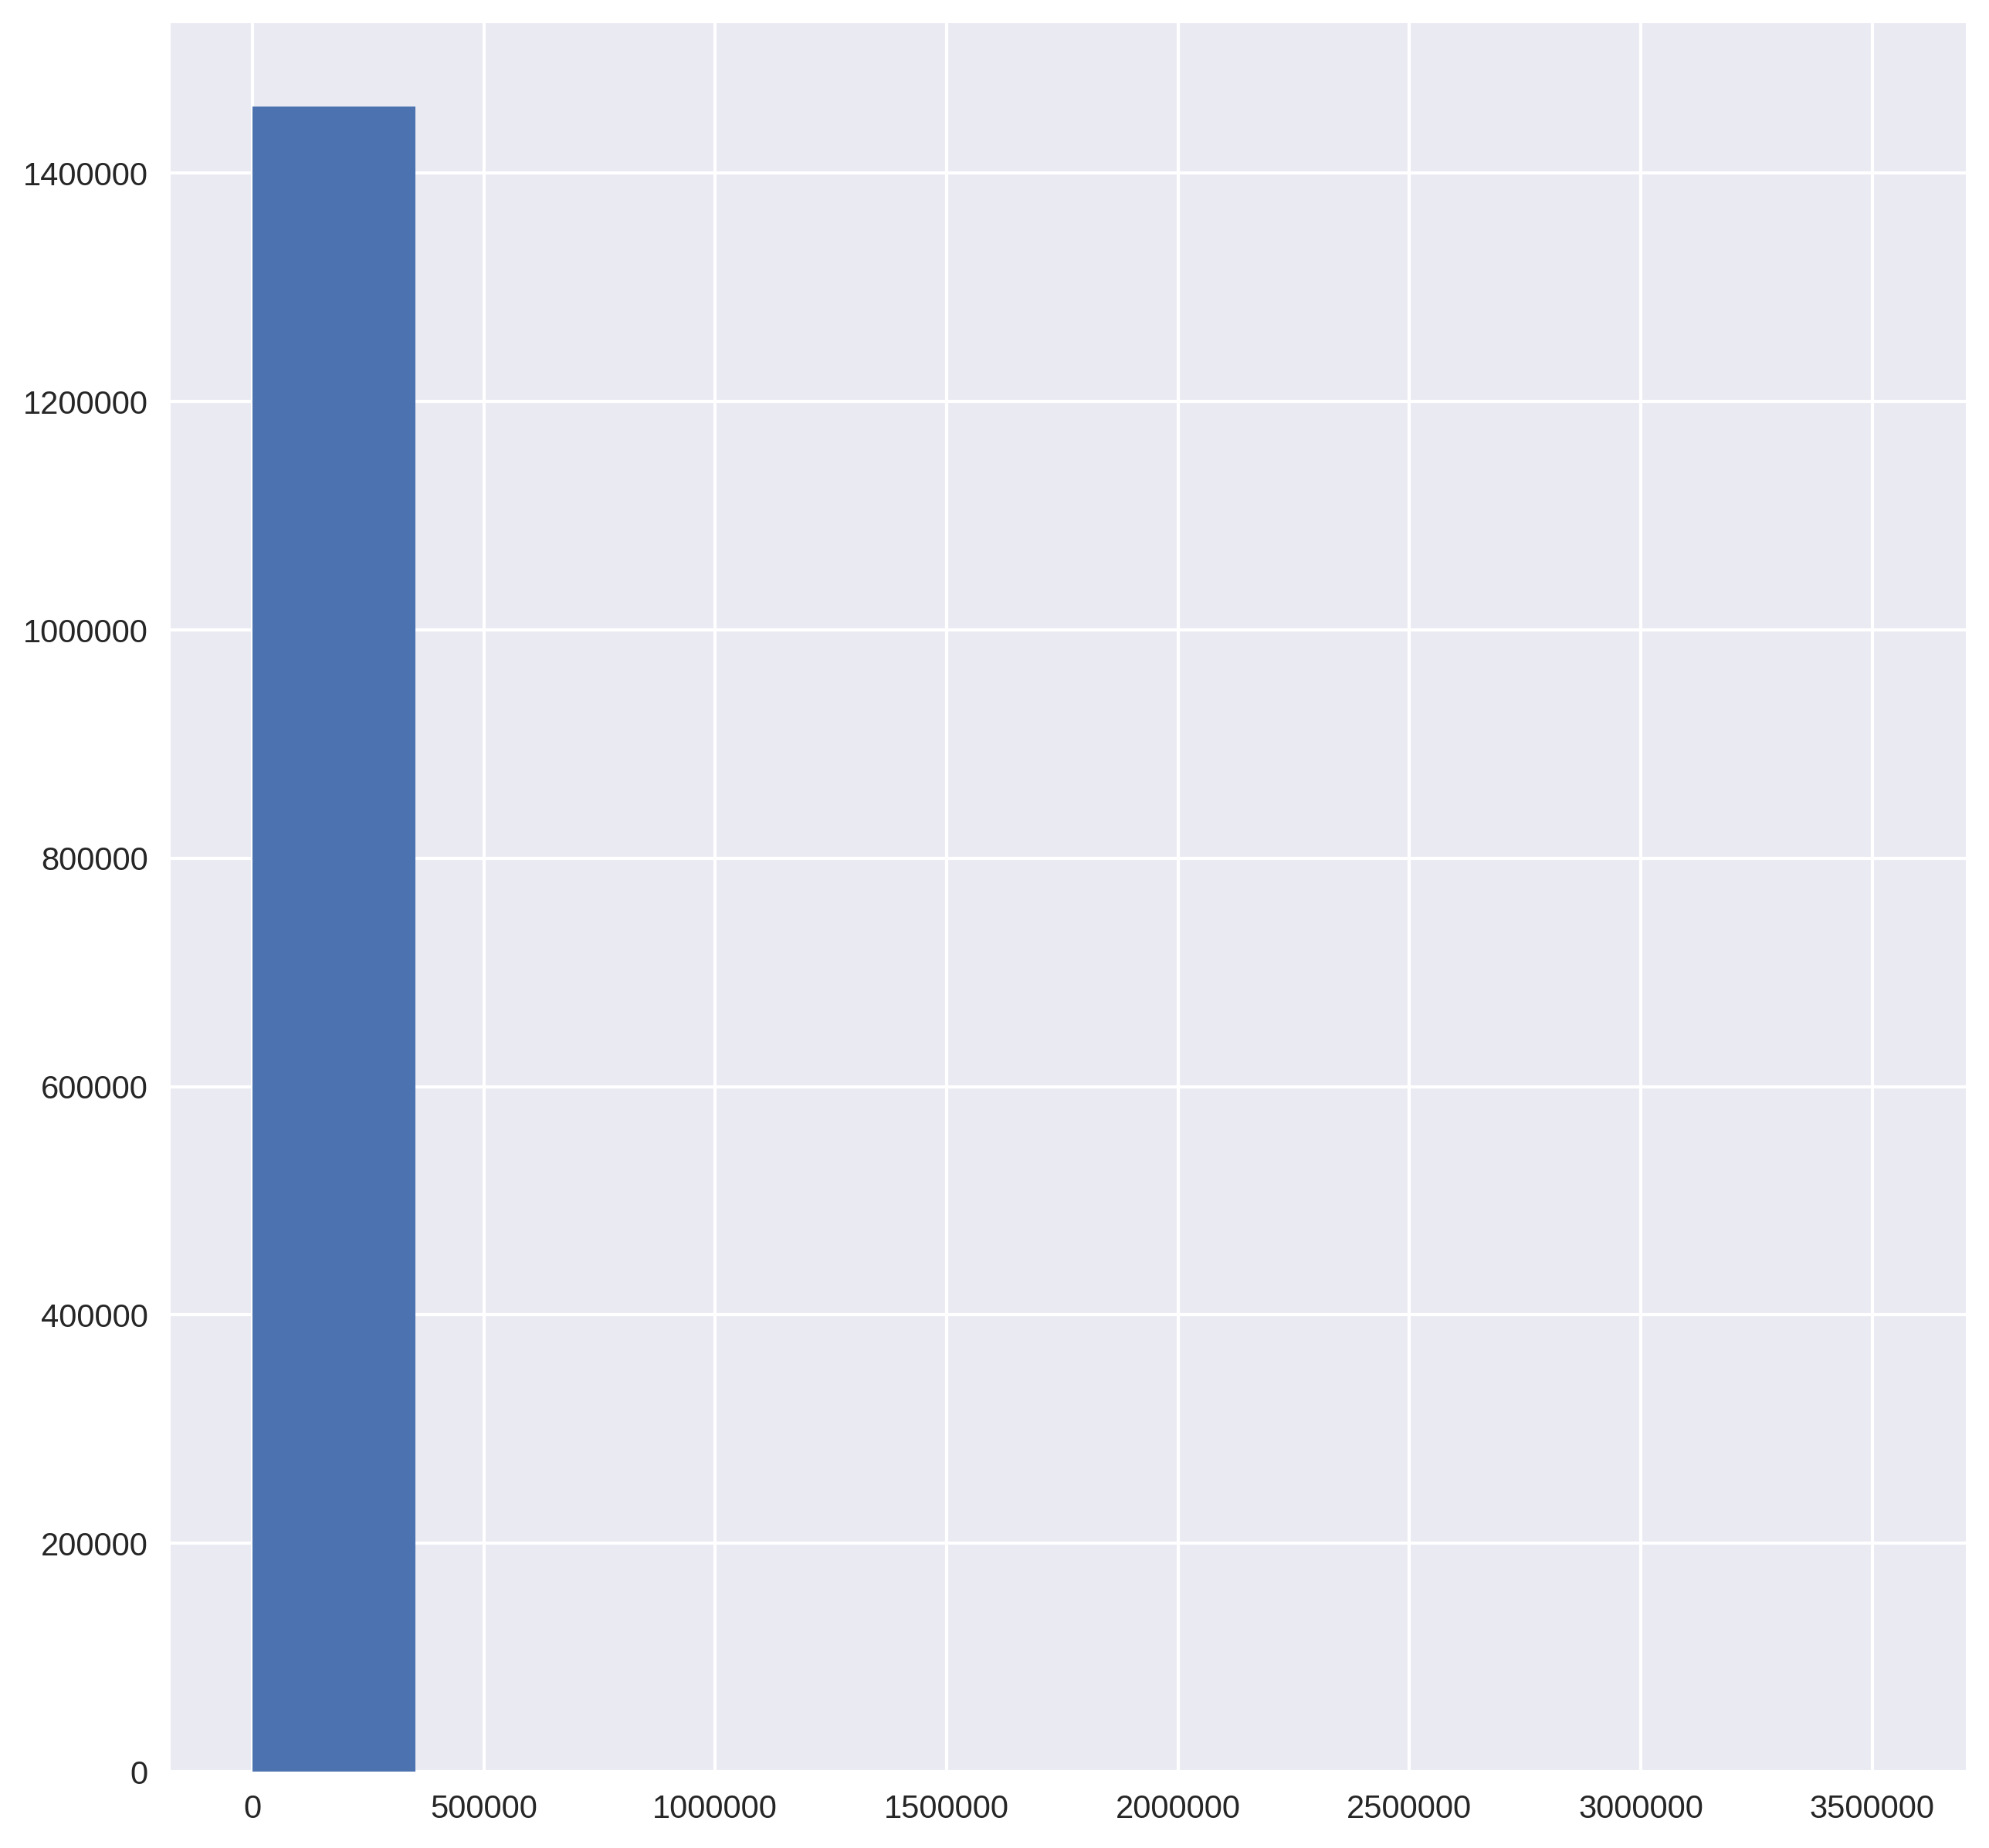

In [411]:
train['trip_duration'].hist(figsize=(10,10))

In [412]:
# the length of y_train must be the same as X_train
print(len(y_train))
print(len(X_train))
print(len(X_test))
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)

1458644
1458644
625134
(1458644, 1)
(1458644, 9)
(625134, 9)


## 4.3 Which features are the best ? 

## 4.3.1 Random Forest

In [413]:
rfr = ske.RandomForestRegressor()

In [414]:
rfr.fit(X_train, y_train); # missing cross validation here 

/root/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [415]:
fet_ind = np.argsort(rfr.feature_importances_)[::-1]
fet_imp = rfr.feature_importances_[fet_ind]

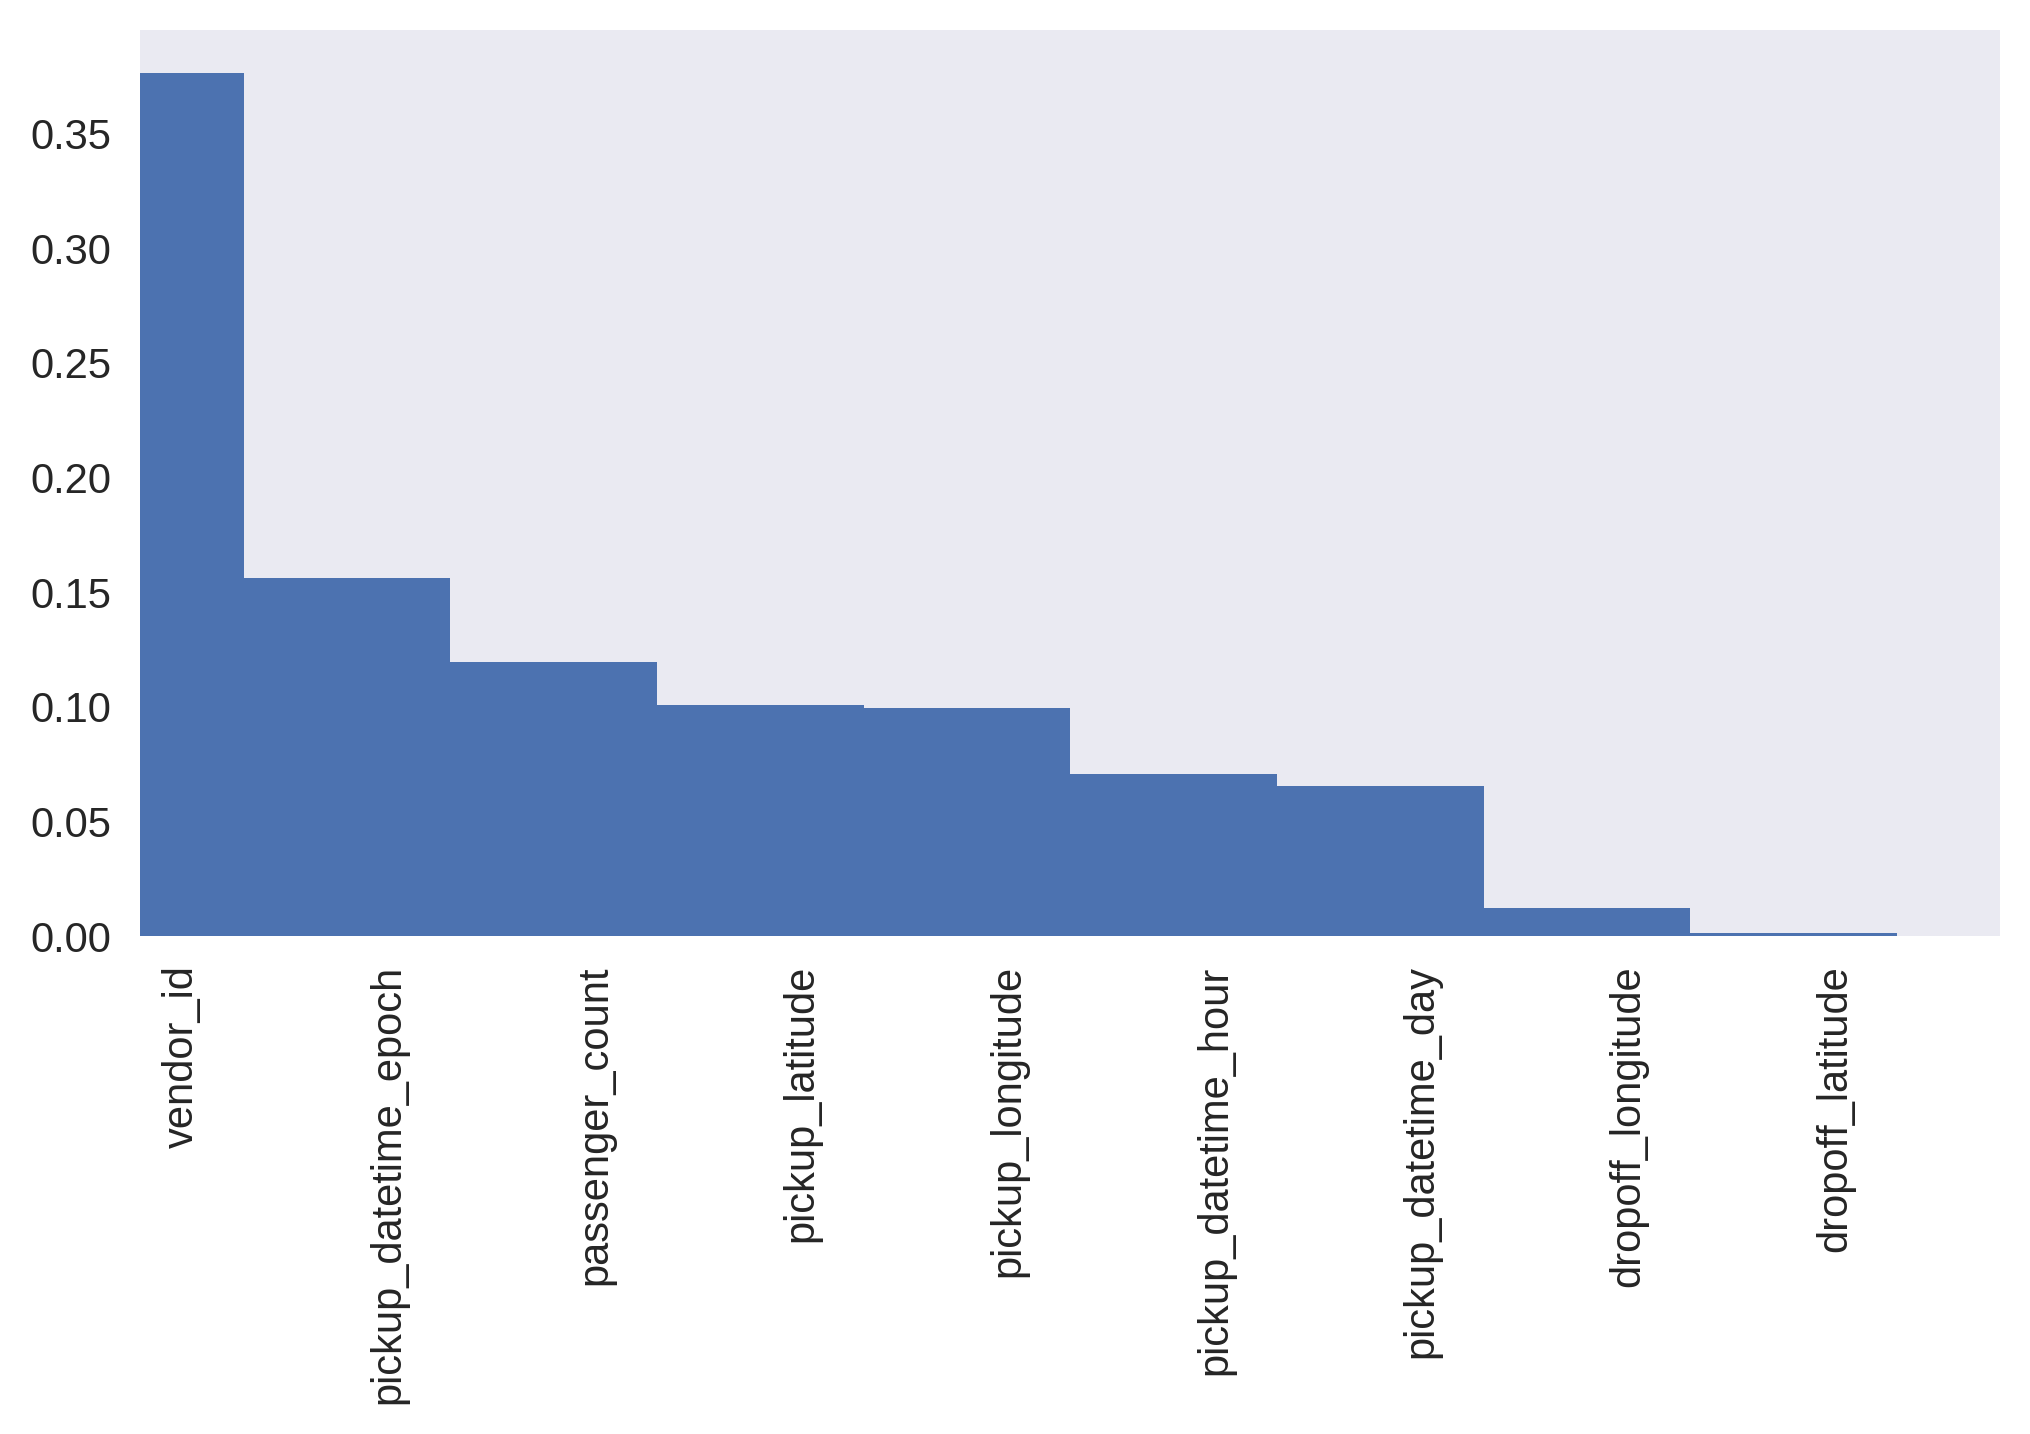

In [416]:
fig = plt.figure(figsize=(8,4));
ax = plt.subplot(111);
plt.bar(np.arange(len(fet_imp)), fet_imp, width=1, lw=2);
plt.grid(False);
ax.set_xticks(np.arange(len(fet_imp))+.2);
ax.set_xticklabels(X_train.columns.values,rotation=90);
plt.xlim(0, len(fet_imp));

In [ ]:
# skrang, hanya ada vendor_id, pickup_datetime_epoch, trip_duration
# sepatutnya, trip_duration nie tak perlu sebab ini adalah target variable
# next, kena buat untuk semua features yg lain.

# - pickup datetime (maybe strong features)
# - passenger count (maybe weak features )
# - pickup longitude and latitude (maybe strong features )
# - dropoff longitude and latitude (maybe strong featurs )
# - store_and_fwd_flag (not sure ) 

## 4.3.2 Decision Tree

In [417]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
tree_model = DecisionTreeRegressor()

In [418]:
tree_model.fit(X_train, y_train); # missing cross validation here 

In [419]:
# what does it meant by mean_squared_error ? 
#dt.fit(X.reshape(-1, 1), Y)
#mean_squared_error(Y, dt.predict(X.reshape(-1, 1)))
mean_squared_error(y_train, tree_model.predict(X_train)) # if zero, of course is good because using X_train

0.0

In [ ]:
#mean_squared_error(y_train, tree_model.predict(X_test)) # if zero, of course is good because using X_train

In [420]:
from sklearn.tree import export_graphviz
import io
from matplotlib import pyplot

In [421]:
from graphviz import Digraph
from graphviz import Source

In [ ]:
export_graphviz(tree_model, out_file='decision_tree.dot')
#dot = Digraph()
#dot.render('/worker/jupyter/18_Kaggle/NewYorkCityTaxiTripDuration/decision_tree.dot', view=True) 

In [ ]:
# need to install graphiz to enable the 'dot' function 
!dot decision_tree.dot -Tpng -o decision_tree.png

![title](decision_tree.png)

In [423]:
fet_ind = np.argsort(tree_model.feature_importances_)[::-1]
fet_imp = tree_model.feature_importances_[fet_ind]

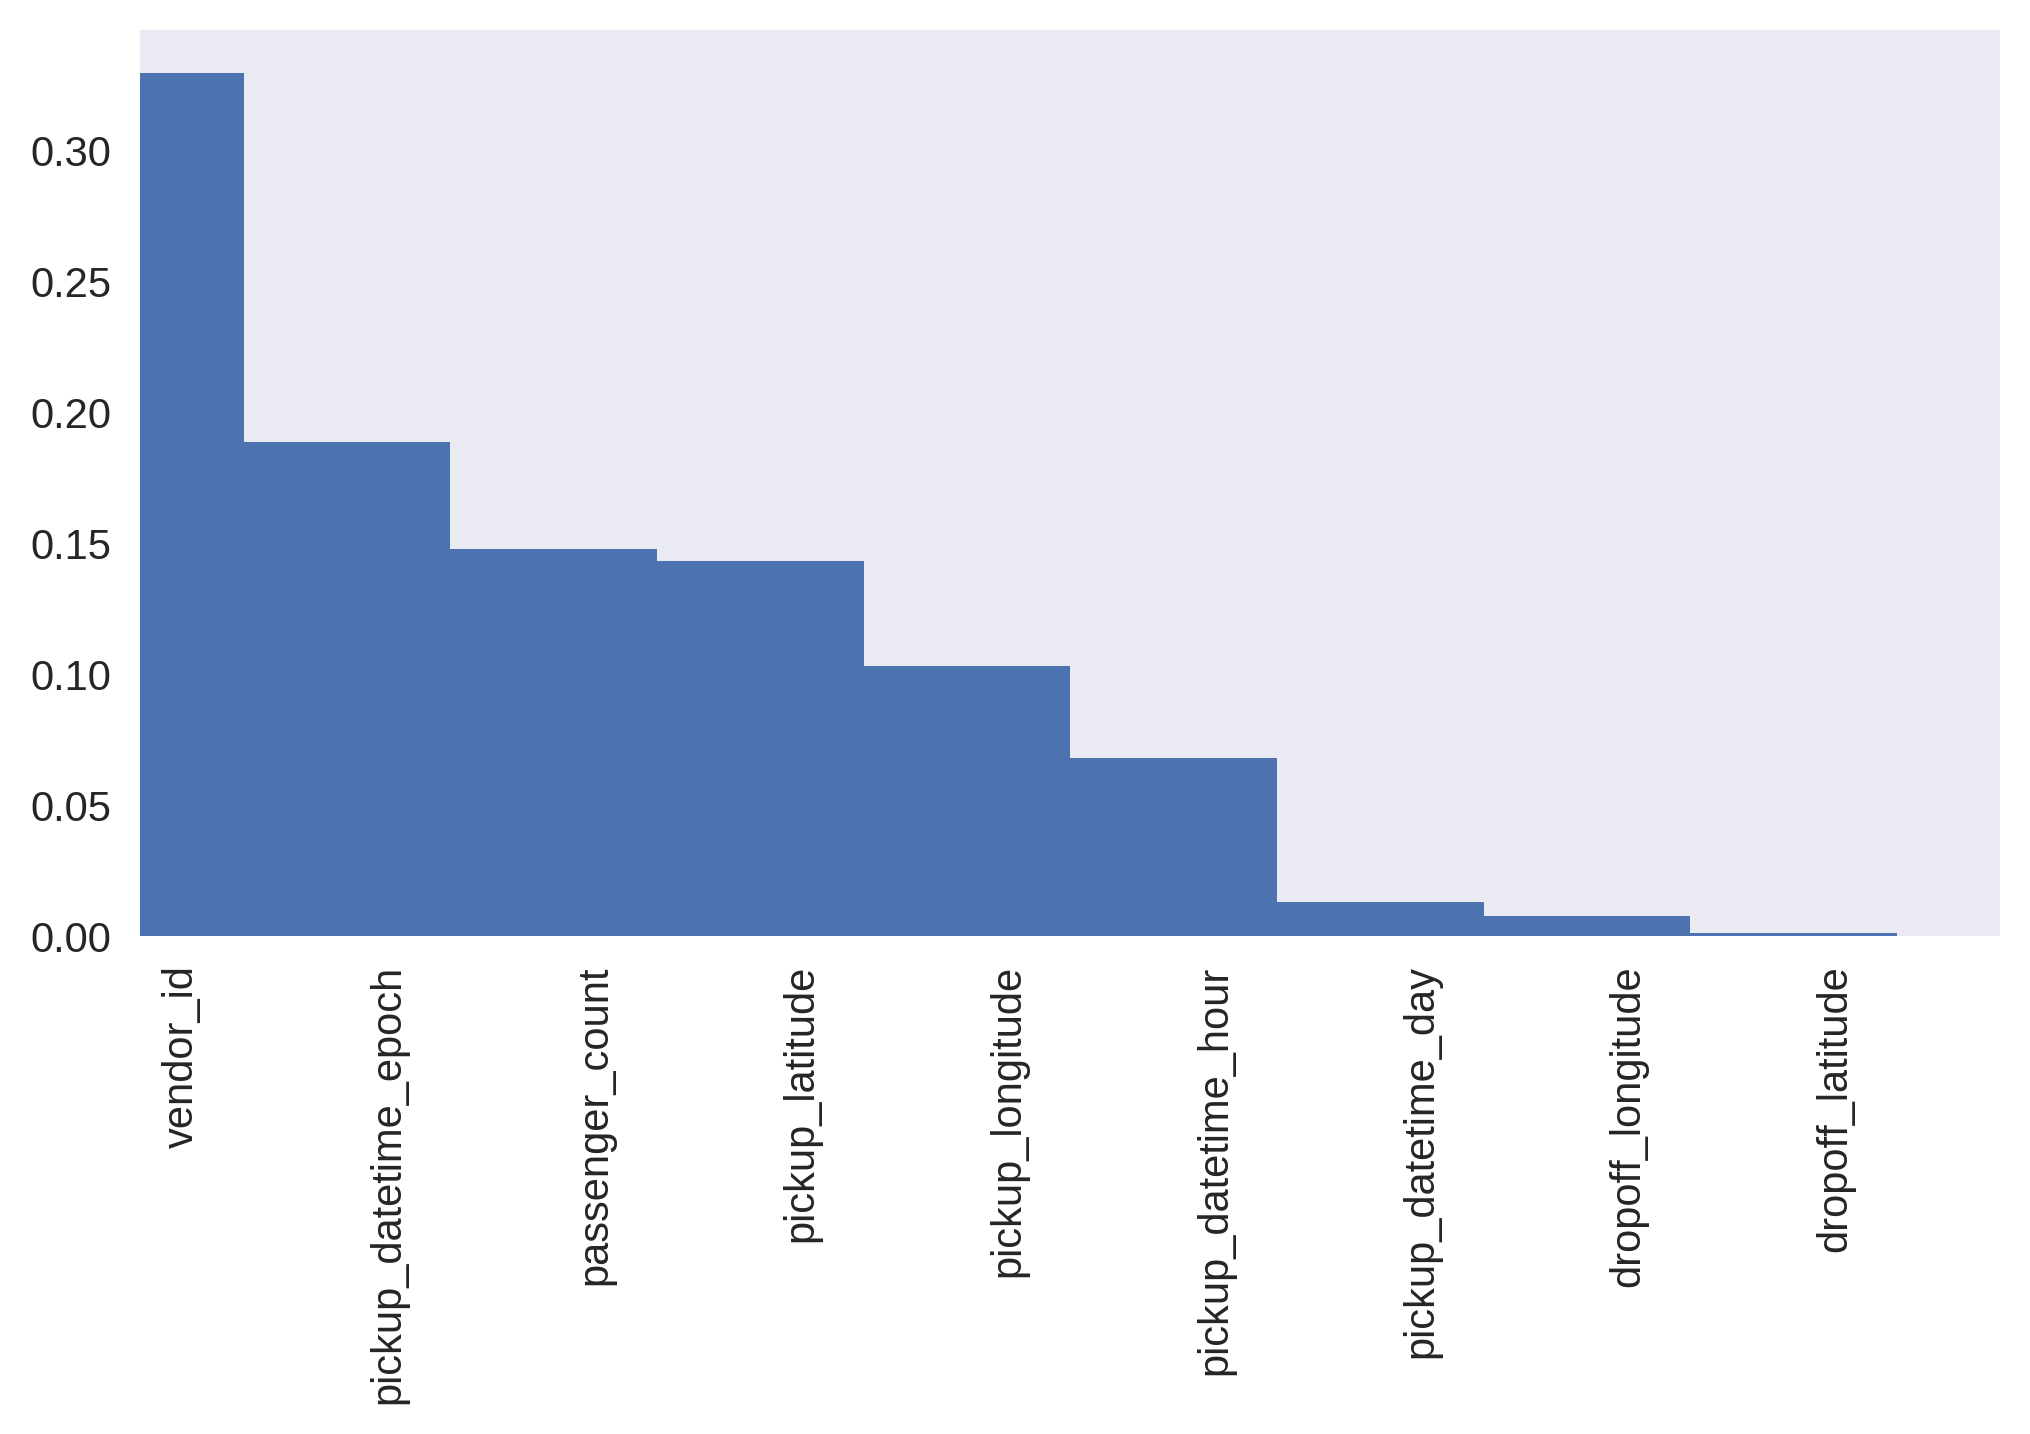

In [424]:
fig = plt.figure(figsize=(8,4));
ax = plt.subplot(111);
plt.bar(np.arange(len(fet_imp)), fet_imp, width=1, lw=2);
plt.grid(False);
ax.set_xticks(np.arange(len(fet_imp))+.2);
ax.set_xticklabels(X_train.columns.values,rotation=90);
plt.xlim(0, len(fet_imp));

## How to convert from LAT LONG of pickup to LAT LONG of dropoff to find the Distance ? 

In [426]:
from geopy.distance import great_circle
# testing area
dengkil = (2.85939, 101.6789782)
ampang = (3.149099,101.7624521)
great_circle(dengkil, ampang).kilometers

33.530619409988

In [427]:
# how to convert 2 columns into tuple
train['pickup_latlong'] = list(zip(train.pickup_latitude,train.pickup_longitude))

In [428]:
train['dropoff_latlong'] = list(zip(train.dropoff_latitude,train.dropoff_longitude))

    Great-circle distance (great_circle) uses a spherical model of the earth, using the mean earth radius as defined by the International Union of Geodesy and Geophysics, (2*a + b)/3 = 6371.0087714150598 kilometers approx 6371.009 km (for WGS-84), resulting in an error of up to about 0.5%. The radius value is stored in distance.EARTH_RADIUS, so it can be customized (it should always be in kilometers, however).
  
   https://en.wikipedia.org/wiki/Great-circle_distance
   
   ![title](great_circle_distance.png)

In [ ]:
train10 = train.head(10)
for i in range(0,len(train10)):
    #print(i)
    train10['distance'][i] = great_circle(train10.pickup_latlong[i], train10.dropoff_latlong[i]).miles

In [ ]:
for i in range(0,len(train)):
    #print(i)
    train['distance'][i] = great_circle(train.pickup_latlong[i], train.dropoff_latlong[i]).miles

In [ ]:
#train.groupby('distance').sum()
#train['distance'][]

In [429]:
train.to_csv("train_newdatetime_dur.csv",index=False)

In [ ]:
## Do the same for TEST data 
test['pickup_latlong'] = list(zip(test.pickup_latitude,test.pickup_longitude))
test['dropoff_latlong'] = list(zip(test.dropoff_latitude,test.dropoff_longitude))
test.to_csv("test_newdatetime_dur.csv",index=False)

In [ ]:
for i in range(0,len(test)):
    #print(i)
    test['distance'] = great_circle(test.pickup_latlong[i], test.dropoff_latlong[i]).miles
test.to_csv("test_newdatetime_duration.csv",index=False)

## 5.0 Prediction of Trip Duration 

## 5.1 Prediction of Trip : Vendor ID (Categorical Features, not a strong features since there are 1,2)

In [430]:
# vendorID_Model
class VendorEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # We get the mean for the whole dataset right away after getting 
        # the dataset grouped by city.  
        # However, we had to join our independent variables to our dependent 
        # variable first in order to do this.  
        joined_df = X.join(y)
        self.vendor_means = joined_df[['vendor_id','trip_duration']].groupby('vendor_id').mean()
        self.total_mean = y.mean()
        return self
    
    def predict(self, X):
        # Super cool list comprehension over rows of X
        # The logic is labelled by number:
        # 1. Take each row in X
        # 2. Check if its' city mean is in the groupby index
        # 3. If not, use the total mean
        # 4. And then add it to the array in the position of the corresponding row
        result = np.array([self.vendor_means.loc[xrow[1]['vendor_id'],'trip_duration'] #4.  
                  if xrow[1]['vendor_id'] in self.vendor_means.index #2.
                  else self.total_mean #3.                                   
                  for xrow in X.iterrows()]) #1.
        return result

## Prediction

In [431]:
# Create object and form prediction
t0 = time()
vendor_model = VendorEstimator()  # initialize
vendor_model.fit(X_train, y_train)  # fit your X training data to your dependent variable.
y_pred = vendor_model.predict(X_test)  # make predictions based on your testing data. 
print("done in %0.3fs." % (time() - t0))

done in 175.638s.


In [432]:
y_pred
print(len(y_pred))

625134


In [433]:
print(X_test.shape)
print(y_pred.shape)

(625134, 9)
(625134,)


In [434]:
# combine the result (y_pred) with the (X_test)
t0 = time()
print("saving the result into csv")
output_vendorid = pd.DataFrame(data={"vendor_id":X_test["vendor_id"],"trip_duration":y_pred})
output.to_csv('output_vendorid.csv',index=False,quoting=3)
print("done in %0.3fs." % (time() - t0))

saving the result into csv
done in 0.003s.


In [435]:
output_vendorid # SUMMARY : who pick up vendor 2 will have more longer trip duration 

,trip_duration,vendor_id
0,845.438244,1
1,845.438244,1
2,845.438244,1
3,1058.643164,2
4,845.438244,1
5,845.438244,1
6,845.438244,1
7,845.438244,1
8,1058.643164,2
9,1058.643164,2


In [ ]:
# graph the table of either vendor 1 or 2 

## 5.3 Features 3 : Passenger Count

In [436]:
class PassengerCountEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, collist):
        self.collist = collist 
        ### When returning the init function, ALWAYS put your self.x = x 
        ### because other functions depend on this convention
        return

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.collist].values

In [437]:
# nop is number of passenger 
PassengerCount_pipeline = pipeline.Pipeline( [
        ('passengercount', PassengerCountEstimator(['passenger_count'])),
        ('estimator', LinearRegression())
    ])

In [438]:
PassengerCount_pipeline.fit(X_train, y_train)

Pipeline(steps=[('passengercount', PassengerCountEstimator(collist=['passenger_count'])), ('estimator', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

## Prediction

In [439]:
y_pred = PassengerCount_pipeline.predict(X_test)
y_pred

array([[ 937.05906836],
       [ 937.05906836],
       [ 937.05906836],
       ..., 
       [ 970.81709394],
       [ 937.05906836],
       [ 970.81709394]])

In [440]:
PassengerCount_pipeline.named_steps['estimator'].coef_ # why coefficient is 33.7 ? 

array([[ 33.75802558]])

In [441]:
print(y_pred.shape)
print(X_test.shape)

(625134, 1)
(625134, 9)


In [442]:
X_test.head(3)

,vendor_id,pickup_datetime_epoch,passenger_count,pickup_latitude,pickup_longitude,pickup_datetime_hour,pickup_datetime_day,dropoff_longitude,dropoff_latitude
0,1,1467331198,1,40.732029,-73.988129,23,3,-73.990173,40.756680
1,1,1467331193,1,40.679993,-73.964203,23,3,-73.959808,40.655403
2,1,1467331187,1,40.737583,-73.997437,23,3,-73.986160,40.729523


In [443]:
print(y_pred.shape)
print(X_test.shape)

(625134, 1)
(625134, 9)


In [449]:
len(y_pred)

625134

In [444]:
type(y_pred)

numpy.ndarray

In [454]:
y_pred2 = y_pred.tolist()

In [456]:
X_test.shape
y_pred.shape
# combine the result (y_pred) with the (X_test) for the business_id
t0 = time()
print("saving the result into csv")
output_passengercount = pd.DataFrame(data={
                                      "passenger_count":X_test["passenger_count"],
                                      "predicted_trip_duration":y_pred2})
output.to_csv('output_predicted_passengercount.csv',index=False,quoting=3)
print("done in %0.3fs." % (time() - t0))

saving the result into csv
done in 1.299s.


In [457]:
output_passengercount.head(5)

,passenger_count,predicted_trip_duration
0,1,[937.0590683626241]
1,1,[937.0590683626241]
2,1,[937.0590683626241]
3,1,[937.0590683626241]
4,1,[937.0590683626241]


## 5.3 Features 3 : Pickup Location (Latitude and Longitude)

In [458]:
from sklearn import grid_search
from sklearn import pipeline
from sklearn.grid_search import GridSearchCV as GSCV
from sklearn.grid_search import ParameterGrid
from sklearn.neighbors import KNeighborsRegressor

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, collist):
        self.collist = collist 
        ### When returning the init function, ALWAYS put your self.x = x 
        ### because other functions depend on this convention
        return

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.collist].values

In [459]:
X_train.head(2)

,vendor_id,pickup_datetime_epoch,passenger_count,pickup_latitude,pickup_longitude,pickup_datetime_hour,pickup_datetime_day,dropoff_longitude,dropoff_latitude
0,2,1457976295,1,40.767937,-73.982155,17,0,-73.964630,40.765602
1,1,1465692215,1,40.738564,-73.980415,0,6,-73.999481,40.731152


In [460]:
cst = ColumnSelectTransformer(['pickup_latitude','pickup_longitude'])
latlongs = cst.transform(X_train)
# Check to see if latlongs match up with that in the dataframe.
#print(latlongs[:5])
#X_train.head()

In [461]:
# Pipeline with KNeighborsRegressor
latlong_pipeline = pipeline.Pipeline([
        ('trans', cst),
        ('est', KNeighborsRegressor(n_neighbors=121)) # 121 is just a guess number , default is 5 
    ])

In [462]:
latlong_pipeline.get_params()

{'est': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=121, p=2,
           weights='uniform'),
 'est__algorithm': 'auto',
 'est__leaf_size': 30,
 'est__metric': 'minkowski',
 'est__metric_params': None,
 'est__n_jobs': 1,
 'est__n_neighbors': 121,
 'est__p': 2,
 'est__weights': 'uniform',
 'steps': [('trans',
   ColumnSelectTransformer(collist=['pickup_latitude', 'pickup_longitude'])),
  ('est',
   KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=121, p=2,
             weights='uniform'))],
 'trans': ColumnSelectTransformer(collist=['pickup_latitude', 'pickup_longitude']),
 'trans__collist': ['pickup_latitude', 'pickup_longitude']}

In [463]:
# Let's run the KNN 
param_grid = {'est__n_neighbors': list(range(1,151,10))}
print(param_grid)

gscv = GSCV(latlong_pipeline, param_grid)
gscv.fit(X_train, y_train)
print("Best estimator--------------------")
print(gscv.best_estimator_)
#print(gscv.)
#print(gscv.best_estimator_.named_steps["est"].feature_importances_)
#print(gscv.best_estimator_.named_steps["est"].)
print("Score---------------------")
print(gscv.score)

{'est__n_neighbors': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141]}
Best estimator--------------------
Pipeline(steps=[('trans', ColumnSelectTransformer(collist=['pickup_latitude', 'pickup_longitude'])), ('est', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=141, p=2,
          weights='uniform'))])
Score---------------------
<bound method BaseSearchCV.score of GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('trans', ColumnSelectTransformer(collist=['pickup_latitude', 'pickup_longitude'])), ('est', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=121, p=2,
          weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'est__n_neighbors': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None

In [467]:
# Run the simulation again around the best parameter from the last cell 
# to get a better more precise value for n_neighbors.
param_grid = {'est__n_neighbors': list(range(130,150,1))} 
print(param_grid)

gscv = GSCV(latlong_pipeline, param_grid)
gscv.fit(X_train, y_train)
print(gscv.best_estimator_)
print(gscv.score)

{'est__n_neighbors': [130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]}
Pipeline(steps=[('trans', ColumnSelectTransformer(collist=['pickup_latitude', 'pickup_longitude'])), ('est', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=149, p=2,
          weights='uniform'))])
<bound method BaseSearchCV.score of GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('trans', ColumnSelectTransformer(collist=['pickup_latitude', 'pickup_longitude'])), ('est', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=121, p=2,
          weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'est__n_neighbors': [130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]},
       pre_dispatch='2*n_jobs', refit=True, sc

## Predict

In [468]:
y_pred = gscv.predict(X_test)

In [469]:
y_pred
print(len(y_pred))

625134


In [470]:
print(X_test.shape)
print(y_pred.shape)

(625134, 9)
(625134, 1)


In [471]:
y_pred2 = y_pred.tolist()

In [477]:
# combine the result (y_pred) with the (X_test) for the pickup_location
t0 = time()
print("saving the result into csv")
output_pickuplocation = pd.DataFrame(data={"pickup_latitude":X_test["pickup_latitude"],
                                           "pickup_longitude":X_test["pickup_longitude"],
                                      "predicted_trip_duration":y_pred2})
print("done in %0.3fs." % (time() - t0))

saving the result into csv
done in 0.049s.


In [478]:
output_pickuplocation.to_csv('output_pickuplocation.csv',index=False,quoting=3)

In [479]:
output_pickuplocation.head(10)

,pickup_latitude,pickup_longitude,predicted_trip_duration
0,40.732029,-73.988129,[676.3020134228188]
1,40.679993,-73.964203,[859.3288590604027]
2,40.737583,-73.997437,[814.744966442953]
3,40.771900,-73.956070,[716.7919463087248]
4,40.761475,-73.970215,[796.6040268456376]
5,40.749798,-73.991302,[849.5302013422819]
6,40.741550,-73.978310,[594.993288590604]
7,40.701527,-74.012711,[986.0134228187919]
8,40.730511,-73.992332,[688.6778523489933]
9,40.748760,-73.993179,[838.5973154362416]
